In [90]:
import os
import sys
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from PIL import Image
import Levenshtein
import string
import numpy as np

sys.path.append(os.path.abspath(os.path.join("../..")))
from src.datasets.huggingfacedataset import HuggingFaceDataset  # noqa: E402
from src.models.convoluationaltransformer.convtrans_v1 import Captcha_Convolutional_Transformer_V1
from src.models.crnn.crnn_v1 import Captcha_CRNN_V1

In [2]:
captcha_transformation = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((40, 150)),
        transforms.ToTensor(),
    ]
)
dataset = HuggingFaceDataset(
    root_dir="/nfs/home/tpz8688/Captcha-Recognition/data/hammer_captchas", 
    transform=captcha_transformation, 
    preload=False
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LSTM Model
model_crnn = Captcha_CRNN_V1(num_chars=len(dataset.vocab) + 1)
state_dict_crnn = torch.load(Captcha_CRNN_V1.SAVE_DIR / "v2.pth", map_location=device)
model_crnn.load_state_dict(state_dict_crnn)
model_crnn.to(device)
model_crnn.eval()
print(f"Model successfully loaded from {Captcha_CRNN_V1.SAVE_DIR / "v2.pth"}")

# Transformer Model
model_transformer = Captcha_Convolutional_Transformer_V1(num_chars=len(dataset.vocab) + 1)
state_dict_transformer = torch.load(Captcha_Convolutional_Transformer_V1.SAVE_DIR / "v2.pth", map_location=device)
model_transformer.load_state_dict(state_dict_transformer)
model_transformer.to(device)
model_transformer.eval()
print(f"Model successfully loaded from {Captcha_Convolutional_Transformer_V1.SAVE_DIR / "v2.pth"}")


Model successfully loaded from /nfs/home/tpz8688/Captcha-Recognition/weights/crnn/v2.pth
Model successfully loaded from /nfs/home/tpz8688/Captcha-Recognition/weights/conv_transformer/v2.pth


/nfs/home/tpz8688/Captcha-Recognition/src/models/convoluationaltransformer/convtrans_v1.py:93: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer = nn.TransformerEncoder(


In [4]:
def decode_predictions(logits, dataset):
    tokens = torch.argmax(logits, dim=-1)

    char_list = []
    for i in range(len(tokens)):
        token = tokens[i].item()
        if token != 0:
            if i > 0 and tokens[i] == tokens[i - 1]:
                continue
            char_list.append(dataset.idx_to_char[token])

    return "".join(char_list)

In [5]:
def captcha_collate_fn(batch):
    images, labels, lengths = zip(*batch)
    
    # Stack images into [Batch, Channels, H, W]
    images = torch.stack(images, 0)
    
    # Pad labels into [Batch, Max_Label_Len_In_Batch]
    # padding_value=0 is the 'blank' index
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)
    
    # Convert lengths to a tensor
    label_lengths = torch.tensor(lengths, dtype=torch.long)
    
    return images, labels_padded, label_lengths

In [6]:
def get_all_predictions(
    model_1,
    model_2,
    dataset,
    device,
    batch_size=256,
    num_workers=8,
    pin_memory=True
):
    model_1.eval()
    model_2.eval()

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=True,
        collate_fn=captcha_collate_fn
    )

    idx_to_char = dataset.idx_to_char  # local reference (faster)
    results = []

    with torch.no_grad():
        for batch_idx, (images, labels, _) in enumerate(
            tqdm(loader, desc="Running inference", total=len(loader))
        ):
            images = images.to(device, non_blocking=True)

            # Forward
            logits_1 = model_1(images)
            logits_2 = model_2(images)
            
            # -----------------------------
            # 1️⃣ Greedy decode (vectorized)
            # -----------------------------
            preds_1 = logits_1.argmax(dim=2)  # [B, T]
            preds_2 = logits_2.argmax(dim=2)  # [B, T]

            # Collapse repeats (vectorized)
            # Compare with shifted version
            shifted_1 = torch.roll(preds_1, shifts=1, dims=1)
            shifted_1[:, 0] = -1  # avoid matching first token
            preds_1 = preds_1 * (preds_1 != shifted_1)

            shifted_2 = torch.roll(preds_2, shifts=1, dims=1)
            shifted_2[:, 0] = -1  # avoid matching first token
            preds_2 = preds_2 * (preds_2 != shifted_2)

            # Remove blanks (0)
            # Now we still loop per sample for string creation,
            # but heavy work is already done in tensor space.
            B = preds_1.size(0)

            for i in range(B):
                # Filter non-zero tokens
                token_ids_1 = preds_1[i][preds_1[i] != 0]
                token_ids_2 = preds_2[i][preds_2[i] != 0]

                # Convert to string
                pred_str_1 = "".join(idx_to_char[t.item()] for t in token_ids_1)
                pred_str_2 = "".join(idx_to_char[t.item()] for t in token_ids_2)

                # True label (already padded)
                true_ids = labels[i][labels[i] != 0]
                actual_str = "".join(idx_to_char[t.item()] for t in true_ids)

                global_index = batch_idx * batch_size + i
                results.append((global_index, actual_str, pred_str_1, pred_str_2))

    return results

In [7]:
results = get_all_predictions(model_crnn, model_transformer, dataset, device)

Running inference:   0%|          | 0/5336 [00:00<?, ?it/s]

In [3]:
df_results = pd.DataFrame(results, columns=["index", "actual", "pred_crnn", "pred_transformer"])
df_results.to_csv("data/error_analysis_results_v1.csv", index=False)

NameError: name 'results' is not defined

In [3]:
def plot_result(dataset, idx):
    # -------- Raw image --------
    img_path = dataset.image_paths[idx]
    raw_img = Image.open(img_path)

    # -------- Transformed image --------
    transformed_img, _, _ = dataset[idx]

    # Handle tensor format automatically
    if transformed_img.ndim == 3 and transformed_img.shape[0] in (1, 3):
        transformed_img = transformed_img.permute(1, 2, 0)

    transformed_img = transformed_img.cpu().numpy()

    # If grayscale, remove last dim
    if transformed_img.shape[-1] == 1:
        transformed_img = transformed_img.squeeze(-1)

    # -------- Plot --------
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].imshow(raw_img)
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(transformed_img, cmap="gray" if transformed_img.ndim == 2 else None)
    axes[1].set_title("Transformed")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
df_results = pd.read_csv("data/error_analysis_results_v1.csv")
df_results.head()

,index,actual,pred_crnn,pred_transformer
0,0,l2eErN,l2eErN,l2eErN
1,1,4WKN,4WKN,4WKN
2,2,SjALrT,SjALrT,SjALrT
3,3,NX4n4N,NX4n4N,NX4n4N
4,4,eFKuTR,eFKuTR,eFKuTR


In [6]:
df_results.dropna(inplace=True)

In [7]:
def compute_cer(df, pred_column):
    actual = df["actual"].values
    pred = df[pred_column].values

    total_distance = 0
    total_chars = 0

    for gt, pr in zip(actual, pred):
        total_distance += Levenshtein.distance(gt, pr)
        total_chars += len(gt)

    return total_distance / total_chars

## CRNN-Analysis

In [20]:
df_results_crnn_errors = df_results[df_results["pred_crnn"] != df_results["actual"]]
df_results_crnn_errors.head()

,index,actual,pred_crnn,pred_transformer
10,10,bcxc4,h7wab,6xx5
12,12,a6whx,h7wab,6xx5
21,21,a2yha,h7wab,6xx5
29,29,5p274,h7wab,6xx5
40,40,bw67f,h7wab,6xx5


In [54]:
print(f"Accuracy: {100 - ((len(df_results_crnn_errors) / len(df_results)) * 100)}")
print(f"CER: {compute_cer(df_results, 'pred_crnn'):.2%}")

Accuracy: 91.44831635731063
CER: 5.54%


### Problem: There are some images which are completely black

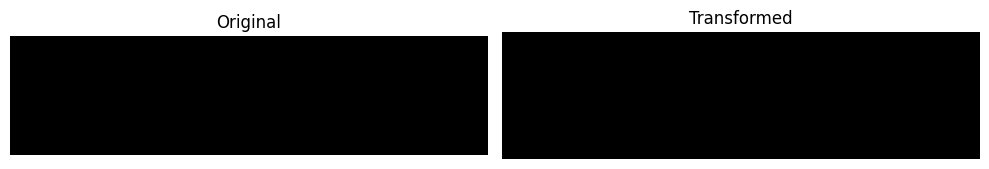

In [22]:
plot_result(dataset, 10)

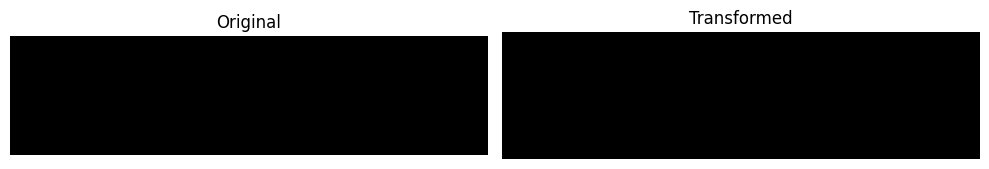

In [23]:
plot_result(dataset, 12)

In [24]:
black_images_mask = (
    (df_results["pred_crnn"] == "h7wab") &
    (df_results["pred_transformer"] == "6xx5")
)

df_results_without_black_images = df_results[~black_images_mask]

print("Number of Black Images:", len(df_results) - len(df_results_without_black_images))

Number of Black Images: 77494


In [55]:
print("Accuracy (excluding black images): "
      f"{100 - ((len(df_results_without_black_images[df_results_without_black_images["pred_crnn"] != df_results_without_black_images["actual"]]) / len(df_results_without_black_images)) * 100)}")
print(f"CER: {compute_cer(df_results_without_black_images, 'pred_crnn'):.2%}")

Accuracy (excluding black images): 96.94889758560147
CER: 0.72%


### There are noisy Labels confusing lowercase with uppercase letters
I filter them out by checking where the CRNN and Transformer prediction agree but the true label differes in lower / uppercase

In [44]:
case_error_mask = (
    # Models agree exactly
    (df_results_without_black_images["pred_crnn"] == df_results_without_black_images["pred_transformer"]) &

    # Case-insensitive match with ground truth
    (df_results_without_black_images["actual"].str.lower() == df_results_without_black_images["pred_crnn"].str.lower()) &

    # But case-sensitive mismatch
    (df_results_without_black_images["actual"] != df_results_without_black_images["pred_crnn"])
)

In [45]:
df_results_without_black_images[case_error_mask]

,index,actual,pred_crnn,pred_transformer
704,704,4dH9M,4DH9M,4DH9M
2933,2933,U5d5b,U5D5B,U5D5B
5524,5524,8tNZS7,8tNzS7,8tNzS7
8233,8233,Gv5pLC,gv5pLC,gv5pLC
9871,9871,fzpLR,fzPLR,fzPLR
...,...,...,...,...
1359369,1359369,CI1ug,cI1ug,cI1ug
1359646,1359646,2h6qX,2h6QX,2h6QX
1365196,1365196,4m91b,4M91B,4M91B
1365384,1365384,KEzh2,KEzH2,KEzH2


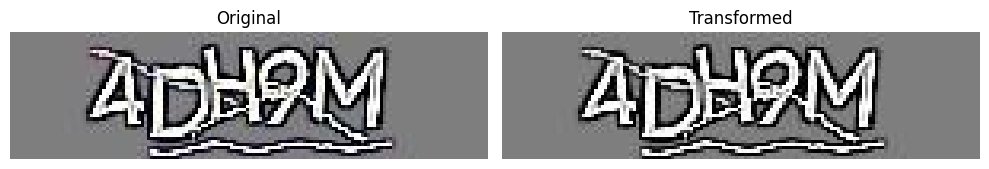

In [42]:
plot_result(dataset, 704) # Label: 4dH9M

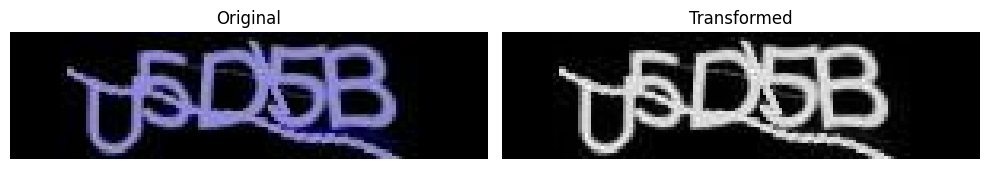

In [43]:
plot_result(dataset, 2933) # Label: U5d5b

In [46]:
df_no_black_no_case_error = df_results_without_black_images[~case_error_mask]

print("Number of Case Confusions:", len(df_results_without_black_images) - len(df_no_black_no_case_error))

Number of Case Confusions: 1470


In [56]:
accuracy = 100 - (
    len(df_no_black_no_case_error[
        df_no_black_no_case_error["pred_crnn"] != df_no_black_no_case_error["actual"]
    ]) / len(df_no_black_no_case_error) * 100
)
print(f"Accuracy (excluding black images & case differences): {accuracy}")
print(f"CER: {compute_cer(df_no_black_no_case_error, 'pred_crnn'):.2%}")

Accuracy (excluding black images & case differences): 97.05964173927099
CER: 0.69%


## Transformer Analysis

In [57]:
df_results_transformer_errors = df_results[df_results["pred_transformer"] != df_results["actual"]]
print(f"Accuracy: {100 - ((len(df_results_transformer_errors) / len(df_results)) * 100)}")
print(f"CER: {compute_cer(df_results, 'pred_transformer'):.2%}")

Accuracy: 91.73436575665814
CER: 5.40%


In [58]:
print("Accuracy (excluding black images): "
      f"{100 - ((len(df_results_without_black_images[df_results_without_black_images["pred_transformer"] != df_results_without_black_images["actual"]]) / len(df_results_without_black_images)) * 100)}")
print(f"CER: {compute_cer(df_results_without_black_images, 'pred_transformer'):.2%}")

Accuracy (excluding black images): 97.25215274683822
CER: 0.64%


In [59]:
accuracy = 100 - (
    len(df_no_black_no_case_error[
        df_no_black_no_case_error["pred_transformer"] != df_no_black_no_case_error["actual"]
    ]) / len(df_no_black_no_case_error) * 100
)
print(f"Accuracy (excluding black images & case differences): {accuracy}")
print(f"CER: {compute_cer(df_no_black_no_case_error, 'pred_transformer'):.2%}")

Accuracy (excluding black images & case differences): 97.36324330708906
CER: 0.61%


# Captcha-Length Error Analysis

In [63]:
df_no_black_no_case_error["actual"].str.len().value_counts()

actual
6    890566
5    235716
4    160527
7        73
2         1
8         1
Name: count, dtype: int64

In [75]:
df_no_black_no_case_error[df_no_black_no_case_error["actual"].str.len() == 2]

,index,actual,pred_crnn,pred_transformer
16245,16245,F7,F7qGx,F7qGcx


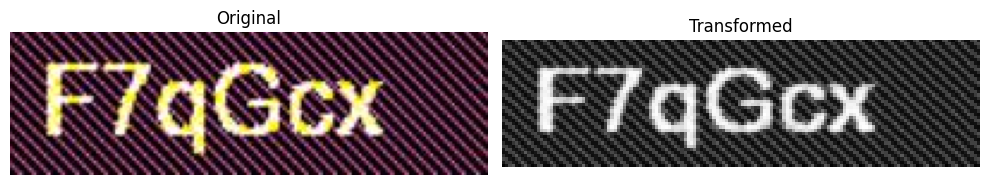

In [ ]:
plot_result(dataset, 16245) # -> Label is wrong

In [77]:
df_no_black_no_case_error[df_no_black_no_case_error["actual"].str.len() == 8]

,index,actual,pred_crnn,pred_transformer
676720,676720,8nce7UNK,8mnce2,8nce7


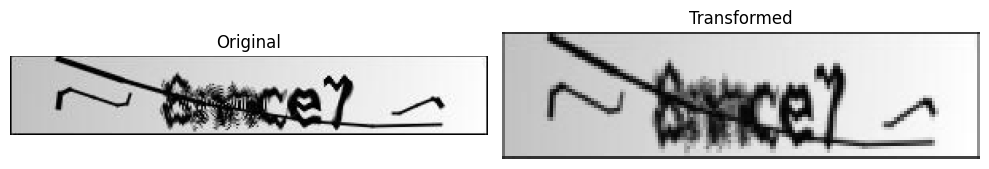

In [78]:
plot_result(dataset, 676720) # -> Label is wrong

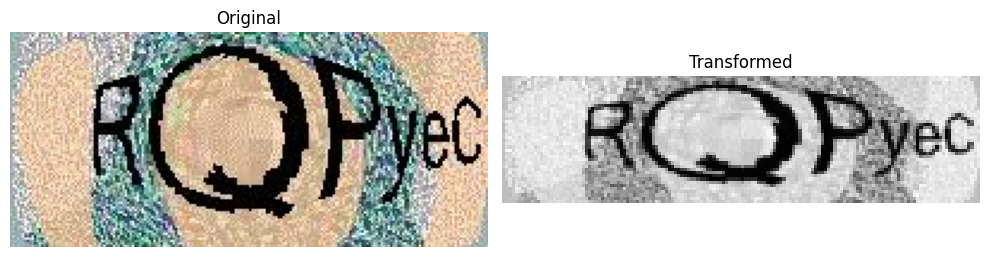

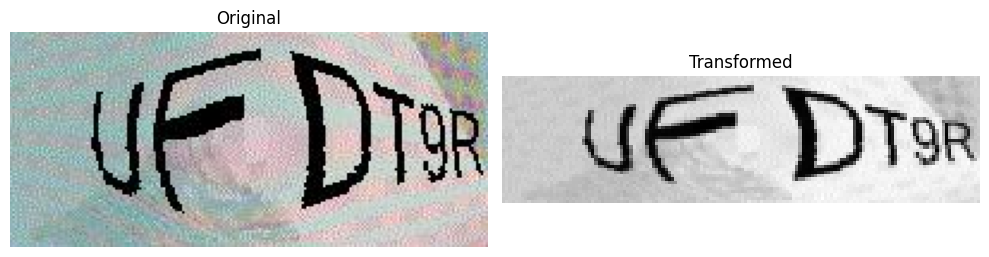

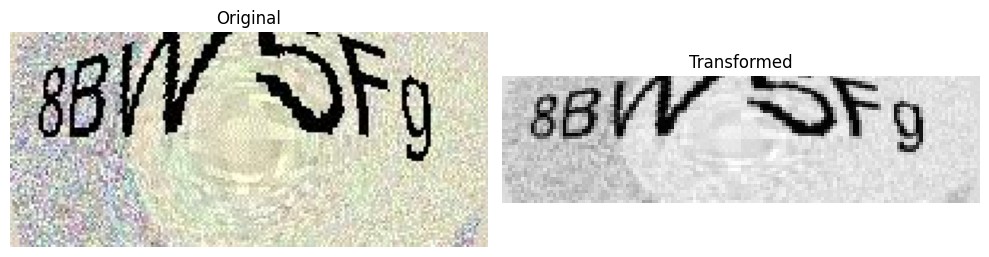

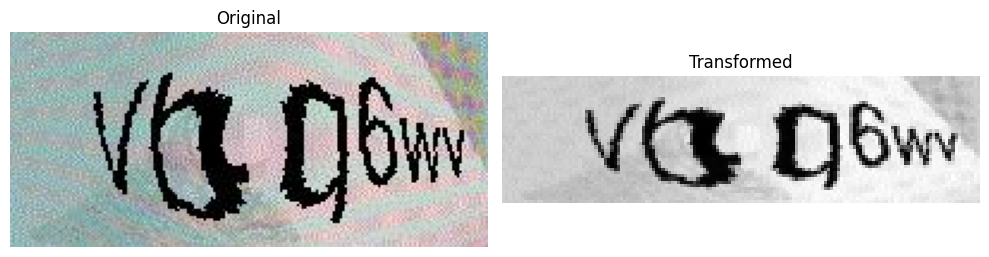

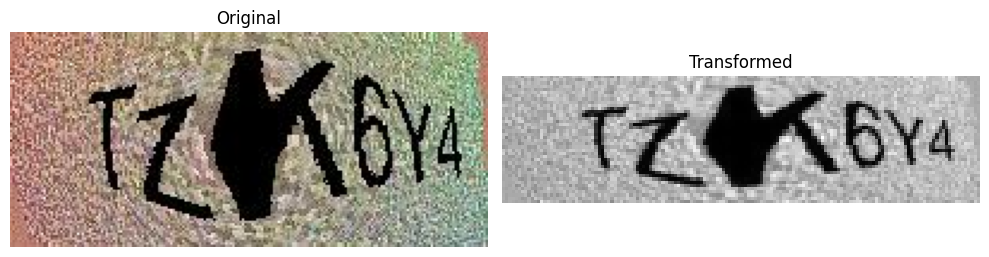

In [84]:
for ctr, (index, _) in enumerate(df_no_black_no_case_error[df_no_black_no_case_error["actual"].str.len() == 7].iterrows()): # Also all wrong labels with length 7
    if ctr == 5:
        break
    plot_result(dataset, index)

In [73]:
label_lengths = []
label_counts = []
crnn_label_length_accuracies = []
transformer_label_length_accuracies = []

for label_len, count in df_no_black_no_case_error["actual"].str.len().value_counts().items():
    label_counts.append(count)
    df_label_len = df_no_black_no_case_error[df_no_black_no_case_error["actual"].str.len() == label_len]
    label_lengths.append(label_len)
    accuracy_transformer = 100 - (
        len(df_label_len[df_label_len["pred_transformer"] != df_label_len["actual"]]) / len(df_label_len) * 100
    )
    accuracy_crnn = 100 - (
        len(df_label_len[df_label_len["pred_crnn"] != df_label_len["actual"]]) / len(df_label_len) * 100
    )
    transformer_label_length_accuracies.append(accuracy_transformer)
    crnn_label_length_accuracies.append(accuracy_crnn)

df_label_length_acc = pd.DataFrame({
    "label_length": label_lengths,
    "label_count": label_counts,
    "accuracy_crnn": crnn_label_length_accuracies,
    "accuracy_transformer": transformer_label_length_accuracies
})

In [74]:
df_label_length_acc

,label_length,label_count,accuracy_crnn,accuracy_transformer
0,6,890566,99.427106,99.448665
1,5,235716,90.315040,91.333215
2,4,160527,93.874551,94.693728
3,7,73,0.000000,0.000000
4,2,1,0.000000,0.000000
5,8,1,0.000000,0.000000


In [86]:
df_no_black_no_case_error_no_wrong_lengths = df_no_black_no_case_error[~df_no_black_no_case_error["actual"].str.len().isin([2, 7, 8])]

# Confusion Matrix

In [91]:
chars = list(string.ascii_letters + string.digits)
char_to_idx = {c: i for i, c in enumerate(chars)}
n_chars = len(chars)

In [94]:
conf_crnn = np.zeros((n_chars, n_chars), dtype=int)
conf_transformer = np.zeros((n_chars, n_chars), dtype=int)

In [95]:
for _, row in df_no_black_no_case_error_no_wrong_lengths.iterrows():
    actual = row["actual"]
    pred_crnn = row["pred_crnn"]
    pred_transformer = row["pred_transformer"]

    # Since wrong lengths were removed, safe to zip
    for a_char, p_crnn, p_trans in zip(actual, pred_crnn, pred_transformer):

        if a_char in char_to_idx:
            a_idx = char_to_idx[a_char]

            # CRNN
            if p_crnn in char_to_idx:
                conf_crnn[a_idx, char_to_idx[p_crnn]] += 1

            # Transformer
            if p_trans in char_to_idx:
                conf_transformer[a_idx, char_to_idx[p_trans]] += 1

In [96]:
df_conf_crnn = pd.DataFrame(conf_crnn, index=chars, columns=chars)
df_conf_transformer = pd.DataFrame(conf_transformer, index=chars, columns=chars)

In [102]:
df_conf_crnn_mismatch = df_conf_crnn.copy()
arr_crnn = df_conf_crnn_mismatch.to_numpy().copy()
np.fill_diagonal(arr_crnn, 0)
df_conf_crnn_mismatch.iloc[:, :] = arr_crnn

df_conf_transformer_mismatch = df_conf_transformer.copy()
arr_trans = df_conf_transformer_mismatch.to_numpy().copy()
np.fill_diagonal(arr_trans, 0)
df_conf_transformer_mismatch.iloc[:, :] = arr_trans

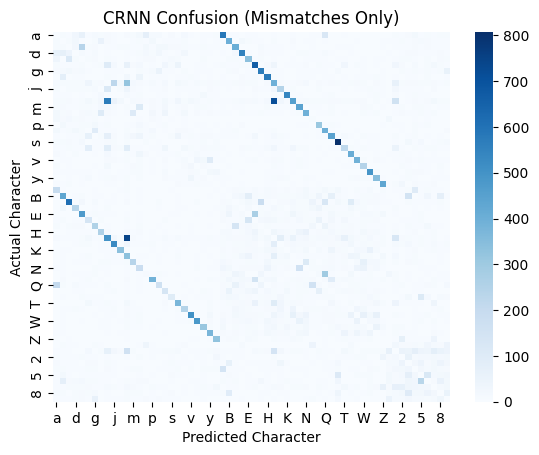

In [111]:
import seaborn as sns

sns.heatmap(df_conf_crnn_mismatch, annot=False, fmt="d", cmap="Blues")
plt.title("CRNN Confusion (Mismatches Only)")
plt.xlabel("Predicted Character")
plt.ylabel("Actual Character")
plt.show()

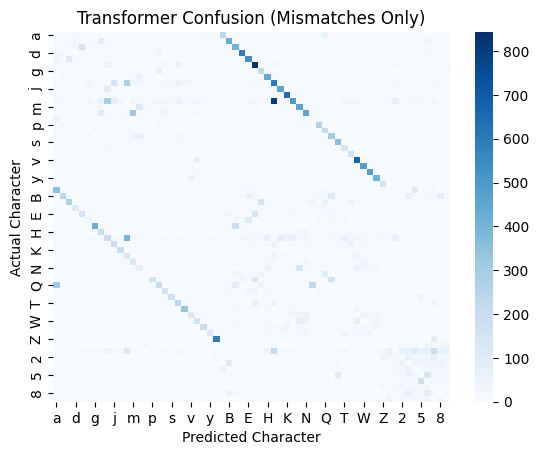

In [110]:
sns.heatmap(df_conf_transformer_mismatch, annot=False, fmt="d", cmap="Blues")
plt.title("Transformer Confusion (Mismatches Only)")
plt.xlabel("Predicted Character")
plt.ylabel("Actual Character")
plt.show()

In [116]:
df_conf_transformer_mismatch.sum().sum()

np.int64(53296)

## Try to find mismatches

In [124]:
crnn_case_mismatch_mask = (
    (df_no_black_no_case_error_no_wrong_lengths["actual"] != df_no_black_no_case_error_no_wrong_lengths["pred_crnn"]) &
    (df_no_black_no_case_error_no_wrong_lengths["actual"].str.lower() == df_no_black_no_case_error_no_wrong_lengths["pred_crnn"].str.lower())
)

df_no_black_no_case_error_no_wrong_lengths[crnn_case_mismatch_mask]

,index,actual,pred_crnn,pred_transformer
430,430,aU2wJ,AU2wj,aU2WJ
486,486,1yXxB,1yXXb,1yXxB
516,516,C7imT,c7iMT,c7IMmT
691,691,XedJl,XEDjL,XEdJl
713,713,cDsH8,cdSH8,CDsH8
...,...,...,...,...
1365379,1365379,1LEte,1LEtE,1LEte
1365522,1365522,4imWs,4imwS,4ImWs
1365581,1365581,WaXcT,Waxct,WaXct
1365649,1365649,Lj7Wz,Lj7WZ,Lj7Wz


Row 0: actual='aU2wJ', pred='AU2wj'


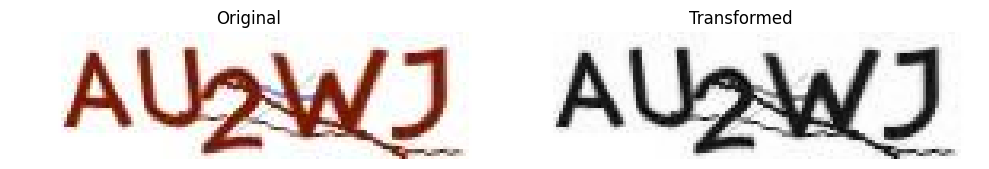

Row 1: actual='1yXxB', pred='1yXXb'


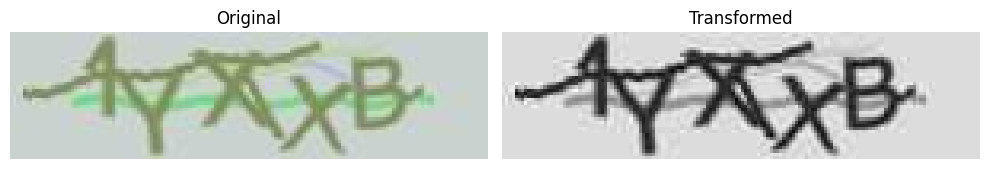

Row 2: actual='C7imT', pred='c7iMT'


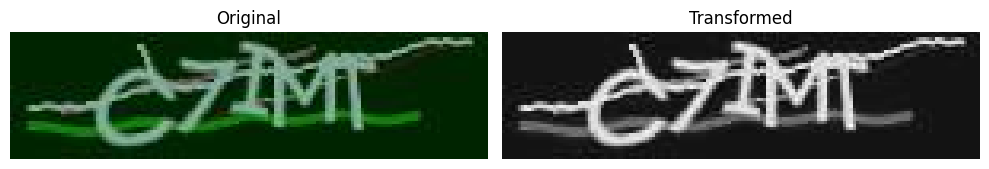

Row 3: actual='XedJl', pred='XEDjL'


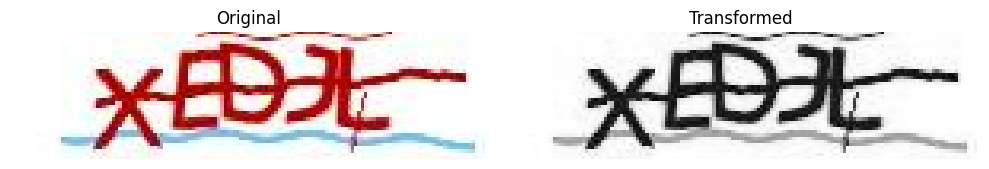

Row 4: actual='cDsH8', pred='cdSH8'


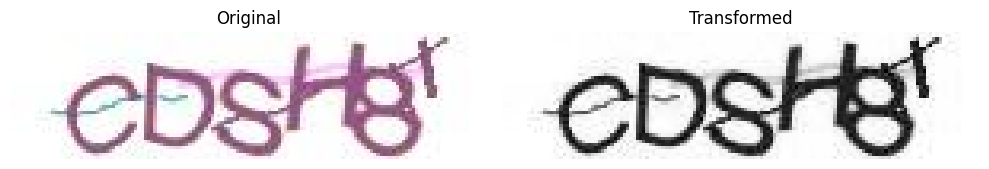

Row 5: actual='Z7w9Cn', pred='Z7w9cn'


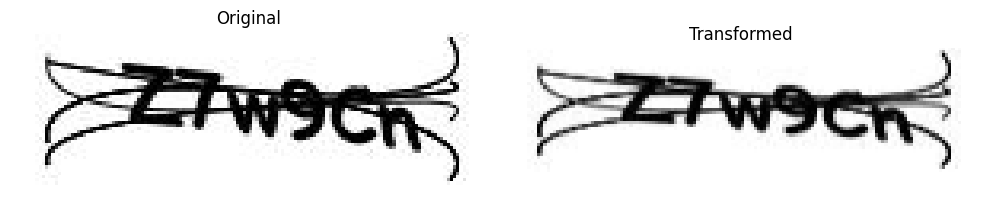

Row 6: actual='3Ubcw', pred='3UBcw'


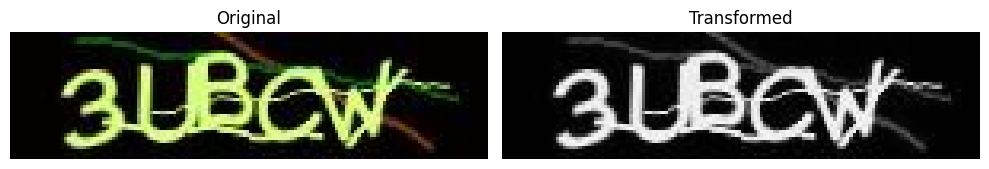

Row 7: actual='UgQl4', pred='UGQl4'


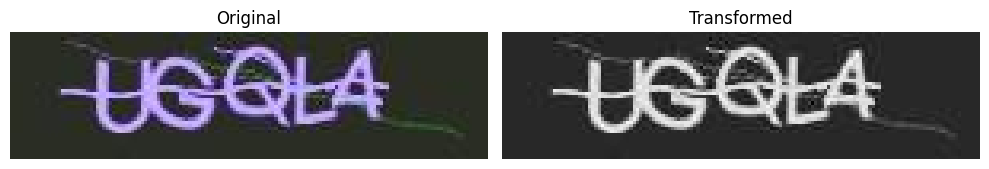

Row 8: actual='EPsNz', pred='ePSnz'


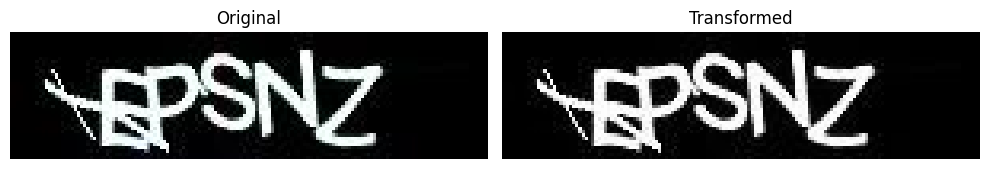

Row 9: actual='GYtuY', pred='GYTuY'


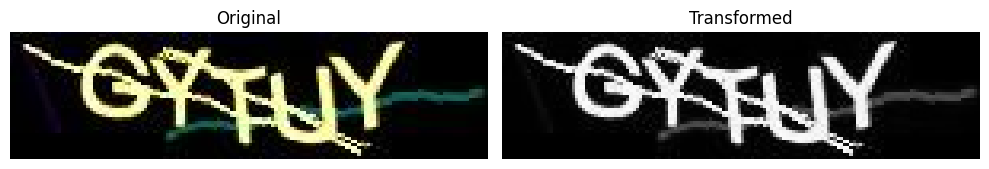

In [125]:
for ctr, (index, row) in enumerate(df_no_black_no_case_error_no_wrong_lengths[crnn_case_mismatch_mask].iterrows()):
    if ctr == 10:
        break
    print(f"Row {ctr}: actual='{row['actual']}', pred='{row['pred_crnn']}'")
    plot_result(dataset, index)

In [126]:
transformer_case_mismatch_mask = (
    (df_no_black_no_case_error_no_wrong_lengths["actual"] != df_no_black_no_case_error_no_wrong_lengths["pred_transformer"]) &
    (df_no_black_no_case_error_no_wrong_lengths["actual"].str.lower() == df_no_black_no_case_error_no_wrong_lengths["pred_transformer"].str.lower())
)

df_no_black_no_case_error_no_wrong_lengths[transformer_case_mismatch_mask]

,index,actual,pred_crnn,pred_transformer
270,270,GDp2FC,GDp2FC,GDp2Fc
318,318,RlJiY,RIlJiY,RLJiY
319,319,9sIss,9SiSsS,9siss
430,430,aU2wJ,AU2wj,aU2WJ
583,583,3PgZCT,3PgZCT,3PgzCT
...,...,...,...,...
1365283,1365283,65Z7g,65z7G,65z7g
1365522,1365522,4imWs,4imwS,4ImWs
1365581,1365581,WaXcT,Waxct,WaXct
1365679,1365679,JtfsO,jtfSO,JtFSO


Row 0: actual='GDp2FC', pred='GDp2Fc'


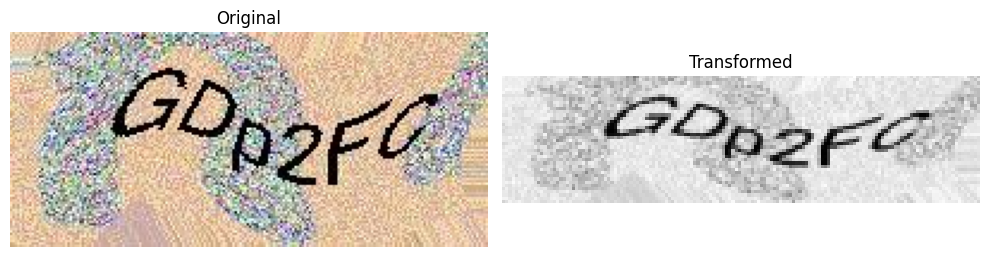

Row 1: actual='RlJiY', pred='RLJiY'


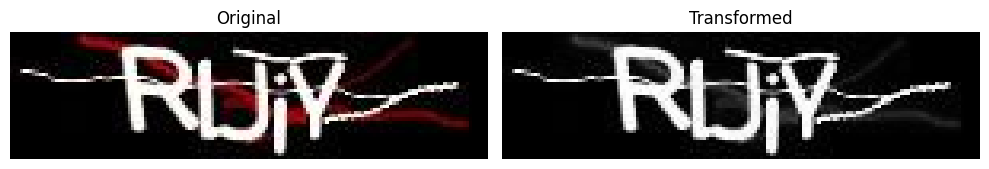

Row 2: actual='9sIss', pred='9siss'


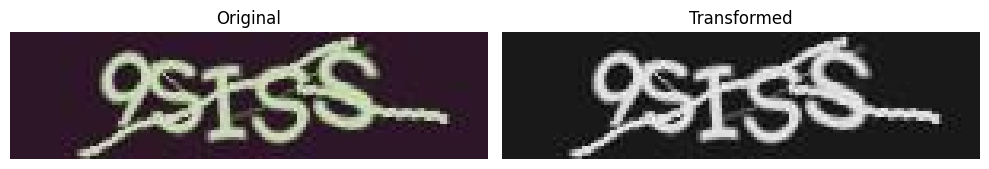

Row 3: actual='aU2wJ', pred='aU2WJ'


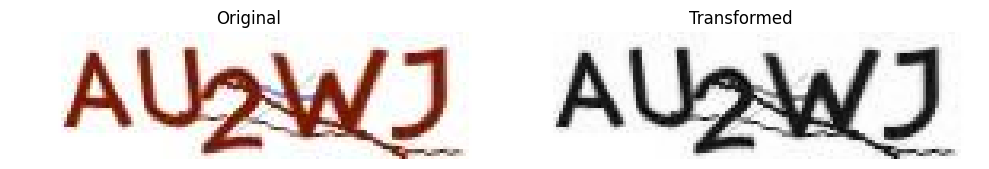

Row 4: actual='3PgZCT', pred='3PgzCT'


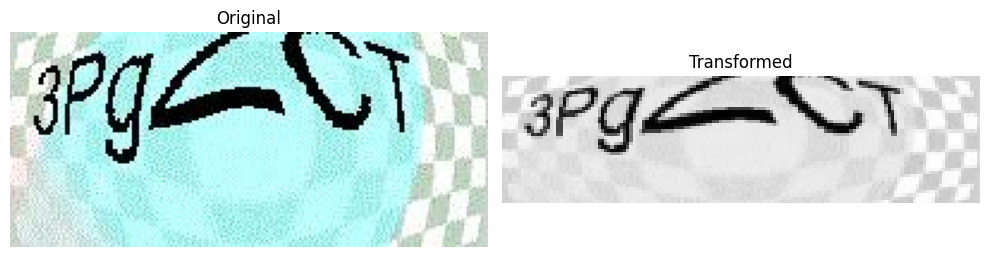

Row 5: actual='L8hB3', pred='L8hb3'


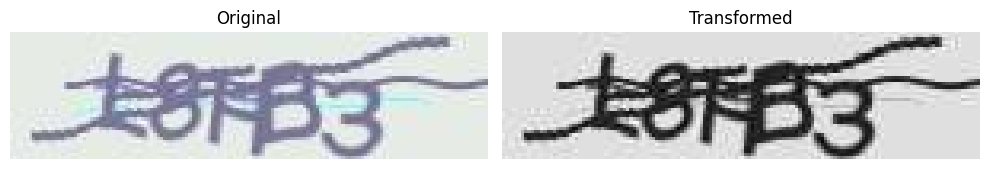

Row 6: actual='XedJl', pred='XEdJl'


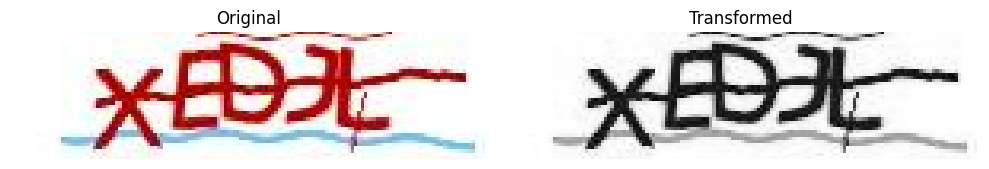

Row 7: actual='cDsH8', pred='CDsH8'


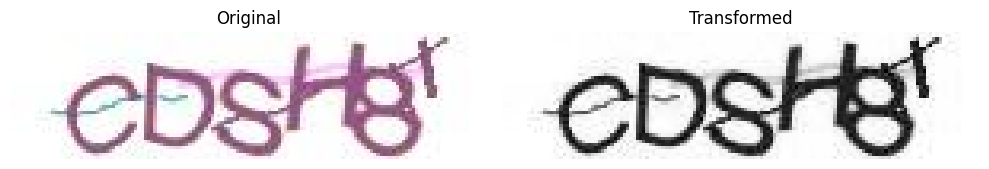

Row 8: actual='ANmRW', pred='ANMRW'


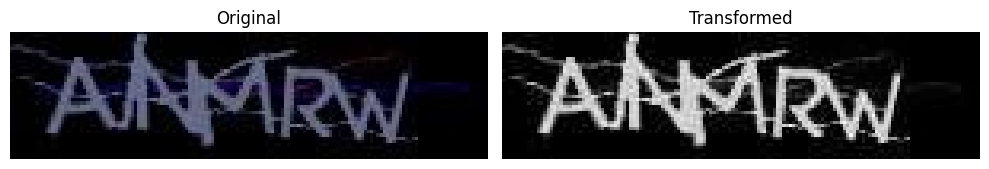

Row 9: actual='3Ubcw', pred='3UBCW'


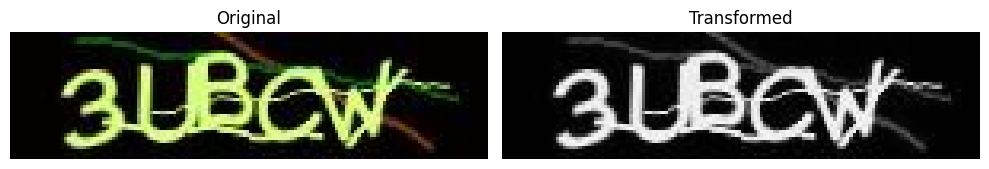

In [127]:
for ctr, (index, row) in enumerate(df_no_black_no_case_error_no_wrong_lengths[transformer_case_mismatch_mask].iterrows()):
    if ctr == 10:
        break
    print(f"Row {ctr}: actual='{row['actual']}', pred='{row['pred_transformer']}'")
    plot_result(dataset, index)

A valid assumption is that if the majority of labels in the dataset are correct, the model has learned the true underlying patterns despite a small fraction of noisy labels; therefore, when predictions from high-confidence models consistently disagree with the provided labels—such as in case mismatches—those labels are likely incorrect. By removing these problematic samples rather than trying to overwrite them with potentially flawed model predictions, we preserve the integrity of the training data, allowing the model to focus on reliable examples and improve its performance in subsequent training iterations without reinforcing label noise.

In [129]:
df_final = df_no_black_no_case_error_no_wrong_lengths[~(crnn_case_mismatch_mask | transformer_case_mismatch_mask)]
df_final.head()

,index,actual,pred_crnn,pred_transformer
0,0,l2eErN,l2eErN,l2eErN
1,1,4WKN,4WKN,4WKN
2,2,SjALrT,SjALrT,SjALrT
3,3,NX4n4N,NX4n4N,NX4n4N
4,4,eFKuTR,eFKuTR,eFKuTR


In [135]:
print(f"Case-Confused Labels: {1 - (len(df_final) / len(df_no_black_no_case_error_no_wrong_lengths)):.2%}")

Case-Confused Labels: 1.14%


$\Rightarrow$ I guess it is safe to remove 1.14% of labels from my dataset

In [142]:
conf_crnn = np.zeros((n_chars, n_chars), dtype=int)
conf_transformer = np.zeros((n_chars, n_chars), dtype=int)

In [143]:
for _, row in df_final.iterrows():
    actual = row["actual"]
    pred_crnn = row["pred_crnn"]
    pred_transformer = row["pred_transformer"]

    # Since wrong lengths were removed, safe to zip
    for a_char, p_crnn, p_trans in zip(actual, pred_crnn, pred_transformer):

        if a_char in char_to_idx:
            a_idx = char_to_idx[a_char]

            # CRNN
            if p_crnn in char_to_idx:
                conf_crnn[a_idx, char_to_idx[p_crnn]] += 1

            # Transformer
            if p_trans in char_to_idx:
                conf_transformer[a_idx, char_to_idx[p_trans]] += 1

In [144]:
df_conf_crnn = pd.DataFrame(conf_crnn, index=chars, columns=chars)
df_conf_transformer = pd.DataFrame(conf_transformer, index=chars, columns=chars)

df_conf_crnn_mismatch = df_conf_crnn.copy()
arr_crnn = df_conf_crnn_mismatch.to_numpy().copy()
np.fill_diagonal(arr_crnn, 0)
df_conf_crnn_mismatch.iloc[:, :] = arr_crnn

df_conf_transformer_mismatch = df_conf_transformer.copy()
arr_trans = df_conf_transformer_mismatch.to_numpy().copy()
np.fill_diagonal(arr_trans, 0)
df_conf_transformer_mismatch.iloc[:, :] = arr_trans

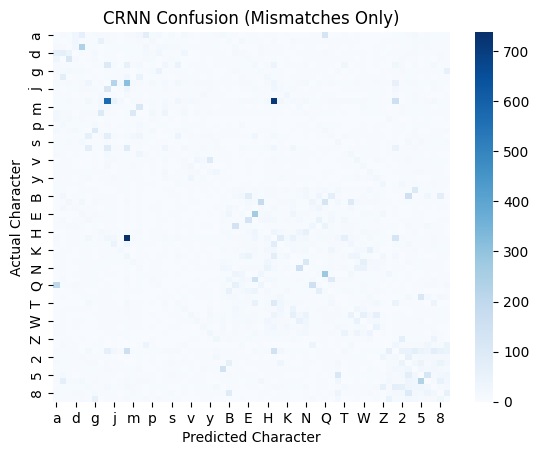

In [145]:
sns.heatmap(df_conf_crnn_mismatch, annot=False, fmt="d", cmap="Blues")
plt.title("CRNN Confusion (Mismatches Only)")
plt.xlabel("Predicted Character")
plt.ylabel("Actual Character")
plt.show()

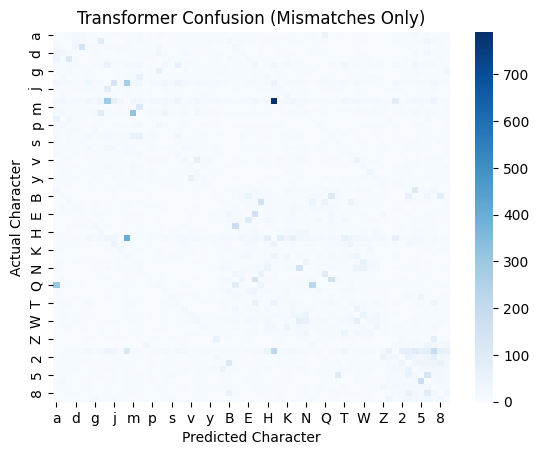

In [146]:
sns.heatmap(df_conf_transformer_mismatch, annot=False, fmt="d", cmap="Blues")
plt.title("Transformer Confusion (Mismatches Only)")
plt.xlabel("Predicted Character")
plt.ylabel("Actual Character")
plt.show()

$\Rightarrow$ The outlier is "I" and "l"

In [147]:
df_conf_transformer_mismatch.sum().sum()

np.int64(36366)

In [151]:
accuracy = 100 - (
    len(df_final[
        df_final["pred_crnn"] != df_final["actual"]
    ]) / len(df_final) * 100
)
print(f"Accuracy (excluding black images & case differences): {accuracy}")
print(f"CER: {compute_cer(df_final, 'pred_crnn'):.2%}")

Accuracy (excluding black images & case differences): 97.97480653671636
CER: 0.42%


In [152]:
accuracy = 100 - (
    len(df_final[
        df_final["pred_transformer"] != df_final["actual"]
    ]) / len(df_final) * 100
)
print(f"Accuracy (excluding black images & case differences): {accuracy}")
print(f"CER: {compute_cer(df_final, 'pred_transformer'):.2%}")

Accuracy (excluding black images & case differences): 98.14240658577003
CER: 0.39%


| Metric                                                     | CRNN  | Transformer |
|------------------------------------------------------------|-------|-------------|
| Accuracy (%)                                               | 91.45 | 91.73       |
| CER (%)                                                    | 5.54  | 5.40        |
| Accuracy excl. Black Images (%)                            | 96.95 | 97.25       |
| CER excl. Black Images (%)                                 | 0.72  | 0.64        |
| Accuracy excl. Black Images & Case Differences (%)         | 97.97 | 98.14       |
| CER excl. Black Images & Case Differences (%)              | 0.42  | 0.39        |


# Create Blacklist

In [157]:
print(f"Remove {(len(df_results) - len(df_final)) / len(df_results):.2%} of the data by excluding black images, case differences, and wrong label lengths")

Remove 6.87% of the data by excluding black images, case differences, and wrong label lengths


In [160]:
clean_indices = df_final.index.tolist()
clean_paths = [str(dataset.image_paths[i]) for i in clean_indices]

with open("clean_images_v2.txt", "w") as f:
    for path in clean_paths:
        f.write(path + "\n")

print(f"Saved {len(clean_paths)} pointers to clean_images_v2.txt")

Saved 1272076 pointers to clean_images_v2.txt
